# Daugiasluoksniai tiesioginės sklaidos neuroniniai tinklai

In [3]:
# https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb

import numpy as np
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

%matplotlib inline

In [5]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1

        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values

In [6]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [95]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr

    # selection of activation function
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr

        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]

        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)

        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr

    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In [8]:
# Loss function

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)


In [14]:
# Calculating accuracy

def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [70]:
# Backward propagation

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]

    # selection of activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)

    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}

    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)

    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]

        dA_curr = dA_prev

        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]

        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]

        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    return grads_values

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [96]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history
    # of metrics calculated during the learning process
    cost_history = []
    accuracy_history = []

    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)

        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)

        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)

    return params_values, cost_history, accuracy_history

In [97]:
# Plot

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(8,6))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [98]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"}
]

X_train = np.array([[0,0],[0,1],[1,0],[1,1]])
Y_train = np.array([0,1,1,1])

params_values, cost_history, accuracy_history = train(X_train.T, np.transpose(Y_train.reshape((Y_train.shape[0], 1))), NN_ARCHITECTURE, 1000, 0.1)

X_test = np.array([[1,1],[1,0],[0,0]])
Y_test = np.array([1,1,0])

Y_hat = full_forward_propagation(X_test.T, params_values, NN_ARCHITECTURE)

#make_plot(X_train, Y_train, 'AND')
#plt.plot(accuracy_history)

grid = np.mgrid[-1:2:100j,-1:2:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

prediction_probs_numpy, _ = full_forward_propagation(grid_2d.T, params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_train, Y_train, "And", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)

4 5 [[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.07678479 0.0906747  0.07440066 0.08348671]
 [0.05805616 0.05026237 0.05548031 0.05024505]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.06709992 0.07368066 0.06934965 0.0786383 ]
 [0.         0.         0.         0.        ]
 [0.1162982  0.11395786 0.11846703 0.12110234]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.02560563 0.02774467 0.02683051 0.02393855]
 [0.         0.         0.         0.        ]
 [0.09649092 0.09955547 0.09814456 0.10612112]
 [0.         0.         0.         0.        ]
 [0.11597166 0.09641883 0.11667306 0.10320768]
 [0.04397743 0.05620086 0.04099294 0.04832857]
 [0.07368

KeyboardInterrupt: 

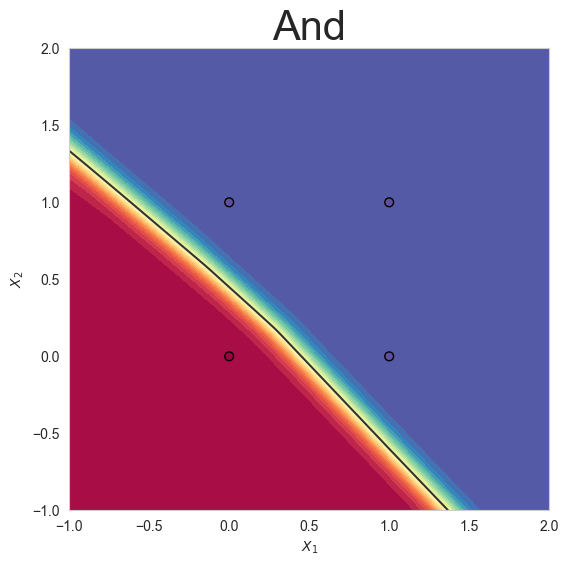

In [65]:
grid = np.mgrid[-1:2:100j,-1:2:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

prediction_probs_numpy, _ = full_forward_propagation(grid_2d.T, params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_train, Y_train, "And", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)

In [ ]:
# Moons dataset

# X, Y = make_moons(n_samples = 100, noise=0.2, random_state=100)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10, random_state=42)
# make_plot(X_train, Y_train, 'Moons')